# Strong lensing with a substructure - a simple example

This notebooks walks the user through a highly simplified example where a dark lensing subclump is present in projction of an extended strongly lensed arc.
The first part generates the image, and in a second part we fit the image with a smooth model. The smooth model fit (within the assumptions) may not be a sufficient description of the data.
All models are analytic and the modelling and mock creation are performed on the same model family. 

This notebook is a modification of the simple Einstein ring example of [lecture III](https://github.com/sibirrer/strong_lensing_lectures/blob/main/Lectures/einstein_ring_III.ipynb).


In [1]:
!pip install lenstronomy
!pip install pyyaml==5.1
!pip install corner
!pip install -e git://github.com/adrn/schwimmbad.git@master#egg=schwimmbad
import shutil
shutil.move("src/schwimmbad/schwimmbad", "./")
import schwimmbad
!pip install emcee

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/opt/local/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/opt/local/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/opt/local/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
Obtaining schwimmbad from git+git://github.com/adrn/schwimmbad.git@master#egg=schwimmbad
  Cloning git://github.com/adrn/schwimmbad.git (to revision master) to ./src/schwimmbad
  Running command git clone -q git://github.com/adrn/schwimmbad.git /Users/sibirrer/Science/Lectures/StrongLensing/strong_lensing_lectures/Examples/src/schwimmbad
  Running command git checkout -b master --track

/Users/sibirrer/Science/Lectures/StrongLensing/strong_lensing_lectures/Examples/schwimmbad/__init__.py:17: UserWarning: Module schwimmbad was already imported from /Users/sibirrer/Science/Lectures/StrongLensing/strong_lensing_lectures/Examples/schwimmbad/__init__.py, but /Users/sibirrer/Science/Lectures/StrongLensing/strong_lensing_lectures/Examples/src/schwimmbad is being added to sys.path
  __version__ = pkg_resources.require(__package__)[0].version


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/opt/local/bin/python -m pip install --upgrade pip' command.


In [2]:
# import of standard python libraries
import numpy as np
import os
import time
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# import lenstronomy routines
from lenstronomy.Util import param_util
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel

## simulation choices
We define the observational conditions and the instrument the mock data is produced with.

In [3]:
# define lens configuration and cosmology (not for lens modelling)
z_lens = 0.5
z_source = 1.5
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
lens_cosmo = LensCosmo(z_lens=0.5, z_source=1.5, cosmo=cosmo)

# data specifics
background_rms = .005  #  background noise per pixel
exp_time = 500.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
# === exercise 1 ===
# change lower the number in the background noise and increase the number in the exposure time and see how the residuals of the fit are changing
numPix = 80  #  cutout pixel size per axis
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width at half maximum of PSF
psf_type = 'GAUSSIAN'  # 'GAUSSIAN', 'PIXEL', 'NONE'



# lensing quantities
kwargs_shear = {'gamma1': 0.0, 'gamma2': -0.05}  # shear values to the source plane
kwargs_pemd = {'theta_E': 1.16, 'gamma': 1.95, 'center_x': 0.0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}  # parameters of the deflector lens model

Msub, csub = 10**11, 6. # halo mass of substructure in M_sol (physical units)
# === exercise 2 ===
# decrease the halo mass of the substructure and see whether there are remaining residual patterns in the fit

# === exercise 3 ===
# change the concentration of the subhalo (c = r200/rs) and see whether this impacts the fit
Rs_angle, alpha_Rs = lens_cosmo.nfw_physical2angle(M=Msub, c=csub)

# === exercise 4 ===
# change the position of the subhalo (indicated as 'center_x' and 'center_y' in the line below, in units of arc seconds)
kwargs_nfw = {'alpha_Rs': alpha_Rs, 'Rs': Rs_angle, 'center_x': 1., 'center_y': 1}
# the lens model is a supperposition of an elliptical lens model with external shear
lens_model_list = ['EPL', 'SHEAR', 'NFW']
kwargs_lens = [kwargs_pemd, kwargs_shear, kwargs_nfw]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# choice of source position
source_x = 0.2
source_y = 0.1


# Sersic parameters in the initial simulation
phi_G, q = 0.5, 0.8
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_source = {'amp': 100, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
#kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic_source]
source_model_class = LightModel(light_model_list=source_model_list)


# lens light model
phi_G, q = 0.9, 0.9
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_lens = {'amp': 200, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': e1, 'e2': e2, 'center_x': 0.0, 'center_y': 0}
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

In [4]:
# import main simulation class of lenstronomy
from lenstronomy.Util import util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

# generate the coordinate grid and image properties (we only read out the relevant lines we need)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numPix, deltapix=deltaPix, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)


kwargs_data = {'background_rms': background_rms,  # rms of background noise
               'exposure_time': exp_time,  # exposure time (or a map per pixel)
               'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
               'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
               'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
               'image_data': np.zeros((numPix, numPix))  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
              }

data_class = ImageData(**kwargs_data)
# generate the psf variables
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 3}

# if you are using a PSF estimate from e.g. a star in the FoV of your exposure, you can set
#kwargs_psf = {'psf_type': 'PIXEL', 'pixel_size': deltaPix, 'kernel_point_source': 'odd numbered 2d grid with centered star/PSF model'}


psf_class = PSF(**kwargs_psf)
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

from lenstronomy.ImSim.image_model import ImageModel
imageModel = ImageModel(data_class, psf_class, lens_model_class=lens_model_class, 
                        source_model_class=source_model_class, lens_light_model_class=lens_light_model_class,
                        kwargs_numerics=kwargs_numerics)

# generate image
image_model = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None)

import lenstronomy.Util.image_util as image_util
poisson = image_util.add_poisson(image_model, exp_time=exp_time)
bkg = image_util.add_background(image_model, sigma_bkd=background_rms)
image_real = image_model + poisson + bkg

data_class.update_data(image_real)
kwargs_data['image_data'] = image_real

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


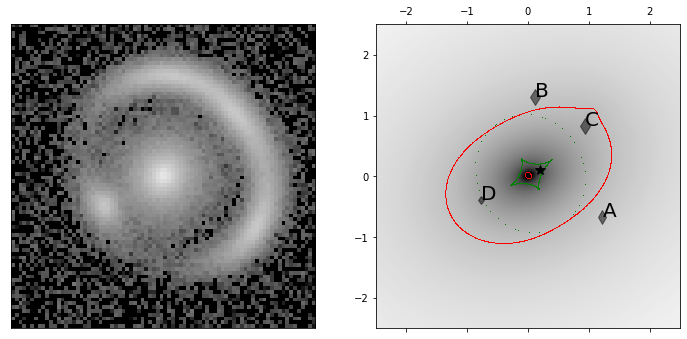

In [7]:
# display the initial simulated image

cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 1

f, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=False, sharey=False)

ax = axes[0]
im = ax.matshow(np.log10(image_real), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)


from lenstronomy.Plots import lens_plot
ax = axes[1]
lens_plot.lens_model_plot(ax, lensModel=lens_model_class, kwargs_lens=kwargs_lens, sourcePos_x=source_x, sourcePos_y=source_y, point_source=True, with_caustics=True, fast_caustic=True)
f.show()


In [8]:
# First we only model the macro-model
lens_model_simple_list = ['EPL', 'SHEAR']

# lens model choicers
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({}) 
kwargs_lens_init.append({'theta_E': 1., 'gamma': 2, 'center_x': 0.0, 'center_y': 0, 'e1': 0., 'e2': 0.})
#kwargs_lens_init.append(kwargs_pemd)
kwargs_lens_sigma.append({'theta_E': .1, 'e1': 0.1, 'e2': 0.1, 'gamma': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens.append({'theta_E': 0.01,'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10, 'center_y': 10})

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append({'gamma1': 0.0, 'gamma2': 0.0})
#kwargs_lens_init.append(kwargs_shear)
kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
kwargs_lens_light_init.append(kwargs_sersic_lens)
kwargs_lens_light_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
kwargs_source_init.append(kwargs_sersic_source)
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.05, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

kwargs_model = {'lens_model_list': lens_model_simple_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                 }

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params}



# numerical options and fitting sequences

num_source_model = len(source_model_list)

kwargs_constraints = {}

kwargs_likelihood = {'check_bounds': True,
                     'source_marg': False,
                    }

image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}
kwargs_init = [kwargs_lens, kwargs_source, kwargs_lens_light, []]


mpi = False  # MPI possible, but not supported through that notebook.

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, mpi=mpi)

fitting_kwargs_list = [['PSO', {'sigma_scale': .1, 'n_particles': 100, 'n_iterations': 100}]]

start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.0205096061678438 reduced X^2 of best position
-3254.405134069254 logL
6378 effective number of data points
[{'theta_E': 1.1825999952895747, 'gamma': 2.105054350329075, 'e1': 0.09460246554289103, 'e2': 0.11623072958291865, 'center_x': 0.008679117692849521, 'center_y': 0.01157266649650517}, {'gamma1': -0.018551510790013128, 'gamma2': -0.0786593584170629, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.12117253834437894, 'n_sersic': 1.0360506550589799, 'e1': 0.06771144442997858, 'e2': 0.12991671397111945, 'center_x': 0.21334979220155484, 'center_y': 0.09909994052977579}] source result
[{'amp': 1, 'R_sersic': 0.2045940784008327, 'n_sersic': 1.9720559433596205, 'e1': -0.005997131805158143, 'e2': 0.035502232188026096, 'center_x': 0.0005438984948207049, 'center_y': -0.000905528126194296}] lens light result
[] point source result
{} special param result
50.43641209602356 time used for  PSO
50

## analyse model output
Here we plot the output. Remember, the NFW subclump (which we did not model here) has also an effect on the macro-model that the mcromodel only fitting wants as goog as possible to compensate for. So the recovered macro-model parameters are not going to be identical with the input parameters.

-1.017001604396642 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.017001604396642


/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/model_band_plot.py:82: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


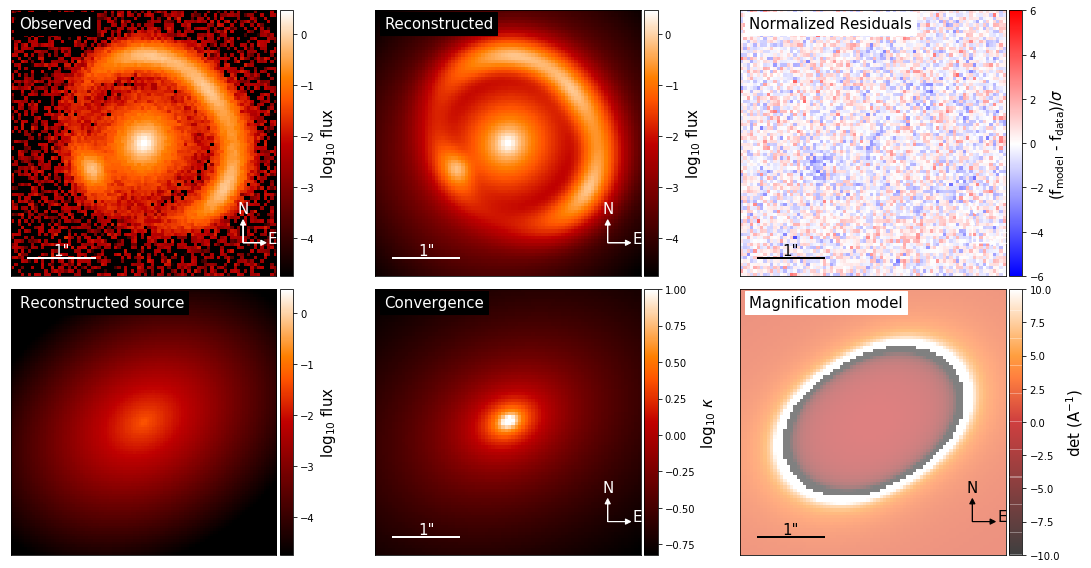

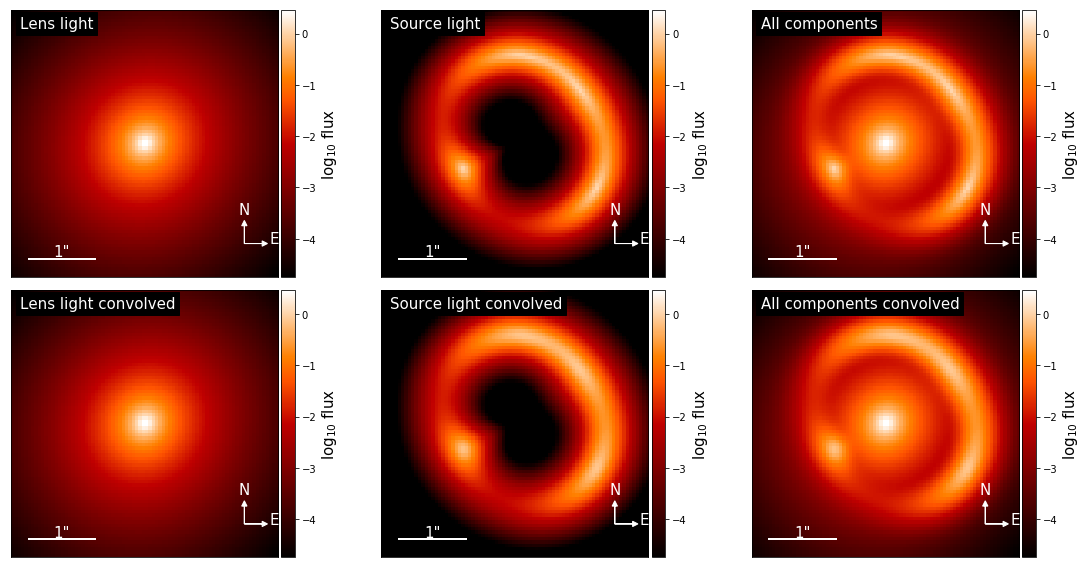

{'kwargs_lens': [{'theta_E': 1.1825999952895747, 'gamma': 2.105054350329075, 'e1': 0.09460246554289103, 'e2': 0.11623072958291865, 'center_x': 0.008679117692849521, 'center_y': 0.01157266649650517}, {'gamma1': -0.018551510790013128, 'gamma2': -0.0786593584170629, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 90.99728191189783, 'R_sersic': 0.12117253834437894, 'n_sersic': 1.0360506550589799, 'e1': 0.06771144442997858, 'e2': 0.12991671397111945, 'center_x': 0.21334979220155484, 'center_y': 0.09909994052977579}], 'kwargs_lens_light': [{'amp': 191.68534780876556, 'R_sersic': 0.2045940784008327, 'n_sersic': 1.9720559433596205, 'e1': -0.005997131805158143, 'e2': 0.035502232188026096, 'center_x': 0.0005438984948207049, 'center_y': -0.000905528126194296}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/model_band_plot.py:517: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data - model), origin='lower', vmin=v_min, vmax=v_max,


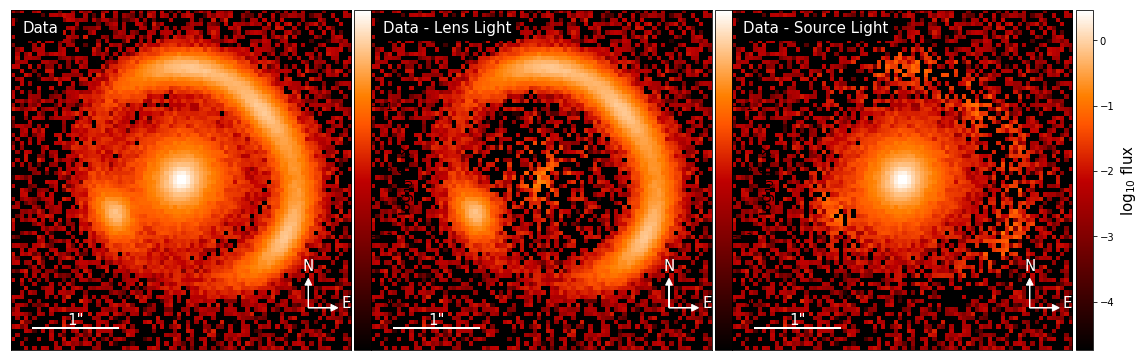

In [9]:
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)
    
f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.subtract_from_data_plot(ax=axes[0], text='Data')
modelPlot.subtract_from_data_plot(ax=axes[1], text='Data - Lens Light', lens_light_add=True)
modelPlot.subtract_from_data_plot(ax=axes[2], text='Data - Source Light', source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

## Exercise 1
You can experiment changing the following observational properties:
- increase/decrease signal-to-noise ratio (increase exposure time and lowering background noise)
- increase/decreae the PSF FWHM
- change pixel scale

# Exercise 2-4
You can experiment changing the following properties of the clump:
- position of the clump
- mass of the clump
- concentration of the clump